In [8]:
from PIL  import ImageGrab as IG
from core import connect   as connect

import pyautogui as     pg
import serial    as     sr
import time      as     tm
import numpy     as     np
import threading as     tr
import os

In [9]:
# Function to get the current mouse position
def get_mouse_position():
    x, y = pg.position()
    return x, y  # Return the current mouse position

    pylon viewer settings 
    to frame image well
    
    Sensor  Width: 288
    Sensor Height: 375
    Offset      x: 768
    Offset      y: 634

In [10]:
# framing for image capture

image_width  = 600
image_height = 885
top_left_x   = 526
top_left_y   = 100

expName = 'image_phi_10_L1000um_d50um_a1.5mm'
os.mkdir(expName)

def peek(fileNameTime):
    bot_right_x = top_left_x + image_width
    bot_right_y = top_left_y + image_height

    sc1 = IG.grab(bbox=(top_left_x, top_left_y, bot_right_x, bot_right_y))
    imageName = expName+'/' + str(fileNameTime) + '.png'
    sc1.save(imageName)
    sc1.close()

In [11]:
print("Finding window location")
tm.sleep(0.1)

# Capture top-left corner
print("Hover mouse over top left corner")
tm.sleep(2)
print('Preparing')
tm.sleep(0.5)
tlx, tly = get_mouse_position()  # Update the tlx, tly values
print(f"Mouse position: ({tlx}, {tly})")

tm.sleep(0.1)

# Capture bottom-right corner
print("Hover mouse over bottom right corner")
tm.sleep(2)
print('Preparing')
tm.sleep(0.5)
brx, bry = get_mouse_position()  # Update the brx, bry values
print(f"Mouse position: ({brx}, {bry})")

# Use the captured positions
test = IG.grab(bbox=(tlx, tly, brx, bry))
test.show()

Finding window location
Hover mouse over top left corner
Preparing
Mouse position: (529, 616)
Hover mouse over bottom right corner
Preparing
Mouse position: (1034, 699)


In [12]:
scanFolderName = 'scanningFolder'

if os.path.exists(scanFolderName):
    print('folder exists')
else:
    os.mkdir(scanFolderName)

def scan():
    channelSlice = IG.grab(bbox=(tlx,tly,brx,bry))
    imageName = scanFolderName+'/slice.png'
    
    channelSlice.save(imageName)
    channelValuesR = list(channelSlice.getdata(band=0))
    channelValuesG = list(channelSlice.getdata(band=1))
    channelValuesB = list(channelSlice.getdata(band=2))
    channelSlice.close()

    # chanValStack = np.vstack([channelValuesR,channelValuesG,channelValuesB])
    # print(chanValStack)
    
    brightness = np.add(np.add(channelValuesR, channelValuesG), channelValuesB) /3 /255
    return brightness
brightness = scan()

folder exists


In [13]:
np.average(brightness)

0.44116538372476516

In [14]:
np.average(brightness)

0.44116538372476516

In [15]:
busy = False 

In [16]:
# get open port info
portinfo = connect.getOpenPorts() 

# 'windows' or 'mac'
deviceType = 'windows'

# MUST set baudrate in pump "System Settings", and MUST match this rate:
baudratePUMP = 9600
baudrateINO  = 38400

useArduino = 0

if deviceType == 'mac':
    print('macDevice')
    # initiate Connection object with first open port
    conn = connect.Connection(port = '/dev/tty.usbserial-A10MLXX5', baudrate = baudratePUMP, x = 0, mode = 0,verbose = False)
    
    if useArduino ==1:
        arduino = sr.Serial(port='/dev/tty.usbmodem2101', baudrate=baudrateINO, timeout=1)
        tm.sleep(2)  # Give some time for the connection to establish
elif deviceType == 'windows':
    print('windowsDevice')
    # initiate Connection object with first open port
    conn = connect.Connection(port = 'COM3', baudrate = baudratePUMP, x = 0, mode = 0,verbose = False)
    
    if useArduino ==1:
        arduino = sr.Serial(port='COM7', baudrate=baudrateINO, timeout=1)
        tm.sleep(2)  # Give some time for the connection to establish

windowsDevice


In [17]:
def WDseq(v,r):
    print("withdrawing", v, "mL, at", r,"ml/min")

    # Open Connection to pump
    conn.openConnection()

    conn.stopPump()

    # Setup parameters for basic run
    units    = 'mL/min'		 	# OPTIONS: 'mL/min','mL/hr','μL/min','μL/hr'
    diameter = 26.8             # 28.6mm diameter - can be set in pump GUI
    volume   = -v              # withdraw 10 mL volume 
    rate     = r                # 5 mL/min flow rate
    runtime  = volume/rate      # this is calculated implictly by pump
    delay    = 0                # 1 is 60 second delay

    # Communicate parameters to pump
    conn.setUnits(units)
    conn.setDiameter(diameter)  
    conn.setVolume(volume)      
    conn.setRate(rate)          
    conn.setDelay(delay)       
    tm.sleep(1)

    # Start pump
    conn.startPump()

In [18]:
def INseq(v,r):
    print("infusing", v, "mL, at", r,"ml/min")
    # Open Connection to pump
    conn.openConnection()

    conn.stopPump()

    # Setup parameters for basic run
    units    = 'mL/min'		 	# OPTIONS: 'mL/min','mL/hr','μL/min','μL/hr'
    diameter = 26.8             # 28.6mm diameter - can be set in pump GUI
    volume   = v              # withdraw 10 mL volume 
    rate     = r                # 5 mL/min flow rate
    runtime  = volume/rate      # this is calculated implictly by pump
    delay    = 0                # 1 is 60 second delay

    # Communicate parameters to pump
    conn.setUnits(units)
    conn.setDiameter(diameter)  
    conn.setVolume(volume)      
    conn.setRate(rate)          
    conn.setDelay(delay)    
       
    tm.sleep(1)

    # Start pump
    conn.startPump()

In [19]:
def unClogSeq(v,r):
    print("begin unclogging")
    global busy
    global running
    
    pump_buffer_time = 2.5
    slowInFactor = 0.25
    flushVolume = 2
    # big infuse
    INseq(v,r)
    tm.sleep(v / r * 60 + pump_buffer_time)

    # cycle 1
    WDseq(flushVolume,r)
    tm.sleep(flushVolume / r * 60 + pump_buffer_time)
    INseq(flushVolume,r * slowInFactor)
    tm.sleep(flushVolume / r / slowInFactor * 60 + pump_buffer_time)

    # # cycle 2
    # WDseq(2.5,r)
    # tm.sleep(2.5 / r * 60 + pump_buffer_time)
    # INseq(2.5,r)
    # tm.sleep(2.5 / r * 60 + pump_buffer_time)

    # # cycle 3
    # WDseq(5,r)
    # tm.sleep(5 / r * 60 + pump_buffer_time)
    # INseq(5,r)
    # tm.sleep(5 / r * 60 + pump_buffer_time)
   
    busy    = False
    running = False

In [20]:
def unClogSeqImage(v,r):
    print("begin unclogging")
    global busy
    global running
    
    pump_buffer_time = 2.5
    slowInFactor = 0.25
    flushVolumeIN = 2 + v
    flushVolumeWD = 2 

    # cycle 1
    WDseq(flushVolumeWD,r)
    tm.sleep(flushVolumeWD / r * 60 + pump_buffer_time)
    
    # infuse all

    INseq(flushVolumeIN,r * slowInFactor)
    tm.sleep(flushVolumeIN / r / slowInFactor * 60 + pump_buffer_time)

    # # cycle 2
    # WDseq(2.5,r)
    # tm.sleep(2.5 / r * 60 + pump_buffer_time)
    # INseq(2.5,r)
    # tm.sleep(2.5 / r * 60 + pump_buffer_time)

    # # cycle 3
    # WDseq(5,r)
    # tm.sleep(5 / r * 60 + pump_buffer_time)
    # INseq(5,r)
    # tm.sleep(5 / r * 60 + pump_buffer_time)
   
    busy    = False
    running = False

In [21]:
def isClog(pressure, clogLim, vinfed):
    global busy
    global t_clog
    global start_time


In [22]:
def runExp(v,r):
    # Open Connection to pump
    conn.openConnection()

    conn.stopPump()

    # Setup parameters for basic run
    units    = 'mL/min'		 	# OPTIONS: 'mL/min','mL/hr','μL/min','μL/hr'
    diameter = 26.8             # 28.6mm diameter - can be set in pump GUI
    volume   = -v               # withdraw 10 mL volume 
    rate     = r                # 5 mL/min flow rate
    runtime  = volume/rate      # this is calculated implictly by pump
    delay    = 0                # 1 is 60 second delay

    # Communicate parameters to pump
    conn.setUnits(units)
    conn.setDiameter(diameter)  
    conn.setVolume(volume)      
    conn.setRate(rate)          
    conn.setDelay(delay)       

    tm.sleep(1)
    # Start pump
    conn.startPump()

In [23]:
# def read_arduino():
#     try:
#         arduino.flushInput()
#         data = arduino.readline()#.decode('utf-8').strip()
#         if data and data.isdigit():
#             return int(data)
#         else:
#             print("here")
#             return None
#     except:
#         # Catch any exception and ignore it
#         print("this here")
#         return None

def read_arduino():
    try:
        arduino.flushInput()  # Clear any junk in the input buffer
        data = arduino.readline().decode('utf-8').strip()
        return int(data)
    except:
        return None


In [24]:
# Function to read from Arduino in a separate thread
def read_arduino_thread():
    global latest_value
    while True:
        value = read_arduino()  # Your function to read from Arduino
        if value is not None:
            latest_value = value
        tm.sleep(0.25)  # Sleep to match Arduino sampling rate

In [25]:
# Function to read from Arduino in a separate thread
def scan_channel_thread():
    global latest_value_image
    global brightnessTracker
    while True:
        value = scan()  # Your function to read all values in image
        if value is not None:
            latest_value_image = np.average(value)
            brightnessTracker.append(np.average(latest_value_image))
        tm.sleep(0.25)  # Sleep to match Arduino sampling rate


In [26]:
#image only system block


global running
global t_clog
global start_time
global latest_value_image
global brightnessTracker

running = False
busy = False

data_list = [0]
time_list = []
time_list_1 = [0]

brightnessTracker = [0]

t_clog = []
latest_value_image = None

exp_run_rate = 0.5 # ml/min
exp_vol      = 30 # ml
start_time   = tm.time()


# Start the Arduino reading thread
threadScan = tr.Thread(target=scan_channel_thread)
threadScan.daemon = True  # Daemon thread will automatically close when the main program exits
threadScan.start()

flowInitializationTime = 5

print(expName)
try:
    while True:
        avgBrightness = latest_value_image
         # print("value is", value, " time is ", tm.time()-start_time)
        tm.sleep(0.1)
        if avgBrightness is not None:
            if not running and not busy:
                running = True
                runExp(v = exp_vol, r = exp_run_rate)
                start_time_clog = tm.time()
                print("running exp for volume", exp_vol, " with flow rate of", exp_run_rate)
                tm.sleep(flowInitializationTime)

            time_running = tm.time() - start_time

            thresholdBrightnesss = 0.8

            if avgBrightness >= thresholdBrightnesss and not busy:
                t_clog     = tm.time() - start_time_clog
                round_time = np.round(tm.time() - start_time, 0)
 
                vinfed = exp_run_rate / 60 * t_clog
                print("value rose to ", avgBrightness, "which is above brightness limit of" ,thresholdBrightnesss )
                print("Time to clog is ", t_clog)
                busy = True
                
                peek(round_time) # take image of clog
                
                unClogSeqImage(v=vinfed, r=50)

                data_list.append(avgBrightness)
                time_list_1.append(t_clog)


except KeyboardInterrupt:
    print("Exiting...")
    conn.stopPump()
    


print("Data collection complete.")


image_phi_10_L1000um_d50um_a1.5mm
running exp for volume 30  with flow rate of 0.5
value rose to  0.8029294580769203 which is above brightness limit of 0.8
Time to clog is  12.65500807762146
begin unclogging
withdrawing 2 mL, at 50 ml/min
infusing 2.1054584006468455 mL, at 12.5 ml/min
running exp for volume 30  with flow rate of 0.5
value rose to  0.8030445369129401 which is above brightness limit of 0.8
Time to clog is  46.870378494262695
begin unclogging
withdrawing 2 mL, at 50 ml/min
infusing 2.390586487452189 mL, at 12.5 ml/min
running exp for volume 30  with flow rate of 0.5
value rose to  0.8013050688484866 which is above brightness limit of 0.8
Time to clog is  53.341979026794434
begin unclogging
withdrawing 2 mL, at 50 ml/min
infusing 2.444516491889954 mL, at 12.5 ml/min
running exp for volume 30  with flow rate of 0.5
value rose to  0.8099113752622604 which is above brightness limit of 0.8
Time to clog is  32.92058181762695
begin unclogging
withdrawing 2 mL, at 50 ml/min
infus

In [28]:
data_list

[0,
 0.8029294580769203,
 0.8030445369129401,
 0.8013050688484866,
 0.8099113752622604,
 0.8002350227935623,
 0.8111532910909801,
 0.8003597383125982,
 0.8082108281699892,
 0.8074702069781748,
 0.8049635466735902,
 0.8142884876722969,
 0.8607366448905699,
 0.8007875883265153,
 0.8022228927357655,
 0.8019655090952043,
 0.8144441715610258,
 0.8002746922459788,
 0.8059078480491564,
 0.8130131709131226,
 0.8548993411034939,
 0.8073109678083328,
 0.801822549370458,
 0.8036318132167577,
 0.8086729211546243,
 0.8056165021179651,
 0.802076284169877,
 0.807396481675099,
 0.8024386421632949,
 0.8033588050513062,
 0.8014179022438034,
 0.8037127426420885,
 0.8103790818486526,
 0.8099424371919829,
 0.8018222686903701,
 0.8001329488016131,
 0.9025029646834279,
 0.80182750805201,
 0.8062790006853272,
 0.8030671784400271,
 0.8000726961427538,
 0.8110366217344626,
 0.8055236905689152,
 0.8013661635476093,
 0.8019296756039886,
 0.8058679914766814,
 0.8046104511230712,
 0.8063377563837179,
 0.80059260922

In [ ]:
import threading
import time as tm
import numpy as np

global running
global t_clog
global start_time
global latest_value

running = False
busy = False

data_list = []
time_list = []
time_list_1 = [0]
pressureOfClog = 93 

t_clog = []
latest_value = None

exp_run_rate = 0.5 # ml/min
exp_vol      = 30 # ml
start_time   = tm.time()


# Start the Arduino reading thread
thread = threading.Thread(target=read_arduino_thread)
thread.daemon = True  # Daemon thread will automatically close when the main program exits
thread.start()

print(expName)
try:
    while True:
        value = latest_value
         # print("value is", value, " time is ", tm.time()-start_time)
        tm.sleep(0.1)
        
        if value is not None and value > 85:
            if not running and not busy:
                running = True
                runExp(v = exp_vol, r = exp_run_rate)
                start_time_clog = tm.time()
                print("running exp for volume", exp_vol, " with flow rate of", exp_run_rate)

            time_running = tm.time() - start_time
            P = value
            cL = pressureOfClog

            if P <= cL and not busy:
                t_clog     = tm.time() - start_time_clog
                round_time = np.round(tm.time() - start_time, 0)
 
                vinfed = exp_run_rate / 60 * t_clog
                print("pressure fell to ", P, "which is below clog limit of" , cL)
                print("Time to clog is ", t_clog)
                busy = True
                
                peek(round_time) # take image of clog
                
                unClogSeq(v=vinfed, r=50)

                time_list_1.append(t_clog)


except KeyboardInterrupt:
    print("Exiting...")
    conn.stopPump()
    


print("Data collection complete.")


In [27]:
print(time_list_1)

[0, 12.65500807762146, 46.870378494262695, 53.341979026794434, 32.92058181762695, 29.186755657196045, 11.450657606124878, 67.55114507675171, 30.36892342567444, 34.79429006576538, 35.29014778137207, 19.52897047996521, 5.007831573486328, 32.016130208969116, 33.929075956344604, 24.47333550453186, 10.354261875152588, 29.842332363128662, 42.650152921676636, 18.727566957473755, 5.000673055648804, 33.86755156517029, 29.887531042099, 40.2832989692688, 26.009310960769653, 32.480103492736816, 31.773949146270752, 29.255329608917236, 10.664628982543945, 56.17641496658325, 37.322551250457764, 57.40325117111206, 30.100217819213867, 24.939359188079834, 9.947781324386597, 162.71750235557556, 5.000256299972534, 41.02904725074768, 23.614803075790405, 24.483327865600586, 47.41995143890381, 70.94903922080994, 32.201523303985596, 55.65118861198425, 29.025849103927612, 49.02682542800903, 36.03759217262268, 26.653589725494385, 9.646230697631836, 29.25540065765381, 30.156903505325317, 29.52890419960022, 51.02

In [29]:
np.size(brightnessTracker)

42147

In [ ]:
global running
global t_clog
global start_time

running = False

data_list = []
time_list = []
pressureOfClog = 90 

t_clog = []

exp_run_rate = 5 # ml/min
exp_vol      = 30 # ml
start_time   = tm.time()

try:
    while True:
        value = read_arduino()
        print("value is", value, " time is ", tm.time()-start_time)
        tm.sleep(0.1)
        if value is not None and value > 85:
            if running is not True and not busy:
                running = True
                runExp(v = exp_vol, r = exp_run_rate)
                start_time_clog = tm.time()
                print("running exp for volume", exp_vol, " with flow rate of", exp_run_rate)

            time_running = tm.time()-start_time
            #time_list.append(time_running)
            #data_list.append(value)
            #pressmBar = (value - 100) * 2000/398
            

            # isClog(pressure = value, clogLim = pressureOfClog, vinfed= volume)
            P = value
            cL = pressureOfClog

            # print("pressure is ", P)
            # print("clog lim is ", cL)
            if P <= cL and not busy:
                t_clog = tm.time() - start_time_clog 
                vinfed = exp_run_rate / 60 * t_clog
                print("pressure fell to ", P, "which is below clog limit of" , cL)
                print("Time to clog is ", t_clog)
                busy = True
                unClogSeq(v=vinfed,r=50)

            # Print the latest value every few seconds (e.g., every 5 seconds)
            round_time = np.round(tm.time() - start_time,0)
            # if round_time % 3 == 0:  # 0.1s * 30 = 3 seconds
            #     print(f"Latest value (after {round_time} seconds): {value}")
            #     # print("press mbar is", pressmBar)
        
except KeyboardInterrupt:
    print("Exiting...")
    # Handle any cleanup if necessary here

print("Data collection complete.")


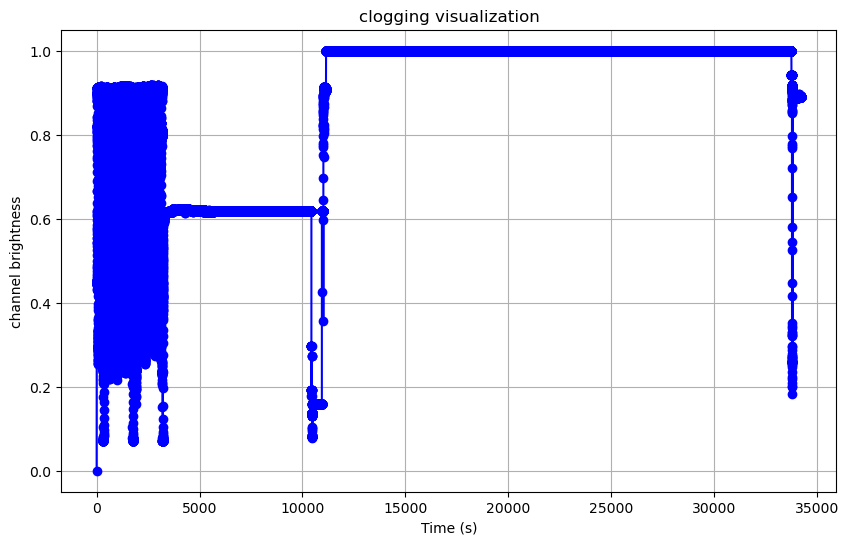

In [41]:
import numpy as np
import matplotlib.pyplot as plt


# Create a time vector with 0.25s intervals
# Assuming y has length N, time vector will have N points
N = len(brightnessTracker)
t = np.arange(0, N * 0.25, 0.25)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, brightnessTracker, marker='o', linestyle='-', color='b')
plt.xlabel('Time (s)')
#plt.xlim([0,600])
plt.ylabel('channel brightness')
plt.title('clogging visualization')
plt.grid(True)
plt.show()


In [40]:
INseq(20,10)

infusing 20 mL, at 10 ml/min


In [39]:
vinfed

0.04167781273523966